In [1]:
from datetime import datetime
from datetime import timezone
import polars as pl
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


start_date = datetime(2023, 9, 1, 0, 0, 0).replace(tzinfo=timezone.utc)
end_date = datetime(2023, 9, 8, 23, 59, 59).replace(tzinfo=timezone.utc)

sensor_id = 2

acropolis_path = "/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Database/Old"
picarro_path = r"/Users/patrickaigner/Documents/PROJECTS/ACROPOLIS/Database/PICARRO"

#Calibration
picarro_slope = 1.0061589132696314
picarro_intercept = 0.14607153970888476

#1.0480372578892292, -5.387930422486534
acropolis_slope = 1.0480372578892292
acropolis_intercept = -5.387930422486534


In [2]:
df = pl.scan_parquet(os.path.join(acropolis_path, "old_db_renamed_measurements.parquet"))

df_a = df.filter(pl.col("system_name") == f"tum-esm-midcost-raspi-{sensor_id}" ).sort("creation_timestamp").filter(pl.col("creation_timestamp").is_between(start_date, end_date))

df_a = df_a.with_columns(((pl.col("gmp343_compensated")/0.98) * acropolis_slope + acropolis_intercept).alias("gmp343_compensated_corr"))

df_a.tail(3).collect()

creation_timestamp,system_name,variant,gmp343_raw,gmp343_compensated,gmp343_filtered,sht45_humidity,bme280_humidity,bme280_pressure,sht45_temperature,bme280_temperature,gmp343_temperature,cal_bottle_id,wxt532_speed_avg,wxt532_speed_max,wxt532_speed_min,wxt532_direction_avg,wxt532_direction_max,wxt532_direction_min,wxt532_last_update_time,raspi_cpu_usage,raspi_disk_usage,raspi_cpu_temperature,enclosure_bme280_humidity,enclosure_bme280_pressure,enclosure_bme280_temperature,cal_gmp343_raw,cal_gmp343_compensated,cal_gmp343_filtered,gmp343_compensated_corr
"datetime[μs, UTC]",str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2023-09-08 15:33:35.200 UTC,"""tum-esm-midcos…","""measurement""",374.7,413.1,413.1,47.0,42.89,951.24,28.58,28.43,31.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,433.129545
2023-09-08 15:33:45.220 UTC,"""tum-esm-midcos…","""measurement""",373.1,411.8,411.8,47.04,42.94,950.59,28.59,28.43,31.1,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,431.730217
2023-09-08 15:33:55.220 UTC,"""tum-esm-midcos…","""measurement""",374.9,414.0,414.0,47.13,43.01,950.1,28.6,28.43,31.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,434.098311


In [3]:
df = pl.scan_parquet(os.path.join(picarro_path, "picarro.parquet"))
df = df.with_columns(pl.col("datetime").dt.cast_time_unit("us").dt.replace_time_zone("UTC").alias("creation_timestamp"))

df_p = df.sort("creation_timestamp").filter(pl.col("creation_timestamp").is_between(start_date, end_date))

df_p = df_p.with_columns((pl.col("CO2_dry") * picarro_slope + picarro_intercept).alias("CO2_corr"))

df_p.tail(3).collect()

DATE,TIME,FRAC_DAYS_SINCE_JAN1,FRAC_HRS_SINCE_JAN1,JULIAN_DAYS,EPOCH_TIME,ALARM_STATUS,INST_STATUS,CavityPressure,CavityTemp,DasTemp,EtalonTemp,species,OutletValve,CH4,CH4_dry,CO2,CO2_dry,h2o_reported,ch4_base,ch4_pzt_std,co2_base,co2_pzt_std,wlm1_offset,wlm2_offset,datetime,__index_level_0__,creation_timestamp,CO2_corr
str,str,f64,f64,f64,f64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,datetime[ns],i64,"datetime[μs, UTC]",f64
"""2023-09-08""","""23:59:56.194""",250.999956,6023.998943,251.999956,1.6942e9,0,963,139.986051,45.000084,42.954075,45.153984,1.0,22535.605997,2.16298,2.213401,457.200552,470.182162,2.200448,1181.504862,71.646525,1084.914228,69.779226,-0.074274,-0.044478,2023-09-08 23:59:56.194,3988372,2023-09-08 23:59:56.194 UTC,473.224044
"""2023-09-08""","""23:59:56.700""",250.999962,6023.999084,251.999962,1.6942e9,0,963,139.995852,45.000084,43.0,45.153984,3.0,22536.69058,2.16298,2.21336,457.200552,470.222845,2.199501,1181.504862,71.646525,1084.914228,69.779226,-0.074274,-0.044478,2023-09-08 23:59:56.700,3988373,2023-09-08 23:59:56.700 UTC,473.264979
"""2023-09-08""","""23:59:58.243""",250.99998,6023.999512,251.99998,1.6942e9,0,963,140.007569,45.000084,43.0,45.153984,2.0,22541.555577,2.163053,2.21336,457.200552,470.222845,2.199501,1181.566184,71.646525,1084.882589,69.779226,-0.074264,-0.044468,2023-09-08 23:59:58.243,3988374,2023-09-08 23:59:58.243 UTC,473.264979


In [4]:
filter = '1h'

df_a = df_a.groupby_dynamic("creation_timestamp", every=filter).agg(
                pl.all().exclude("creation_timestamp").mean())

df_p = df_p.groupby_dynamic("creation_timestamp", every=filter).agg(
                pl.all().exclude("creation_timestamp").mean())

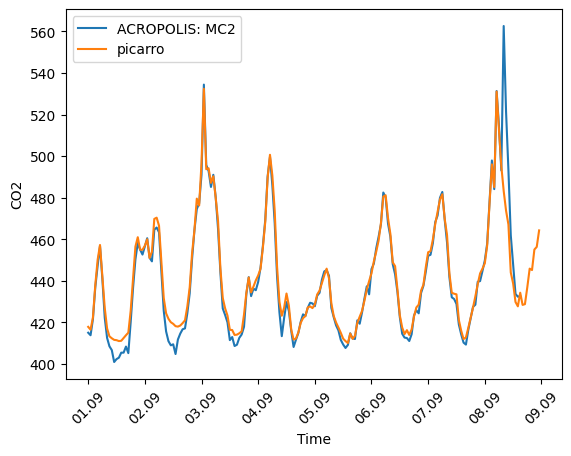

In [5]:
sns.lineplot(data=df_a.collect(), x="creation_timestamp", y="gmp343_compensated_corr", label = f"ACROPOLIS: MC{sensor_id}")
sns.lineplot(data=df_p.collect(), x="creation_timestamp", y="CO2_corr", label = "picarro")

# set axes labels
plt.xlabel("Time")
plt.ylabel('CO2')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d.%m"))

# show the plot
plt.show()

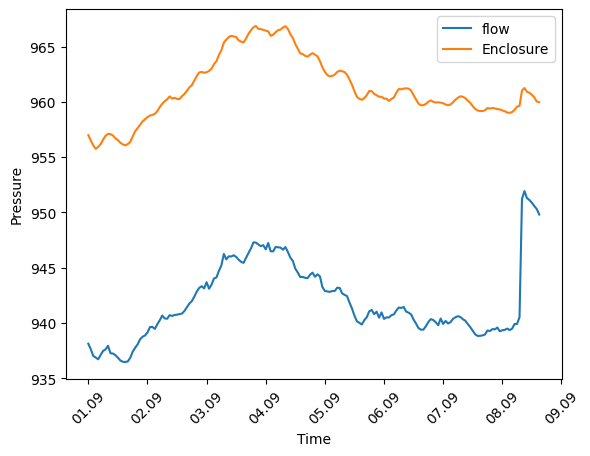

In [6]:
sns.lineplot(data=df_a.collect(), x="creation_timestamp", y="bme280_pressure", label = f"flow")
sns.lineplot(data=df_a.collect(), x="creation_timestamp", y="enclosure_bme280_pressure", label = f"Enclosure")

# set axes labels
plt.xlabel("Time")
plt.ylabel('Pressure')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d.%m"))

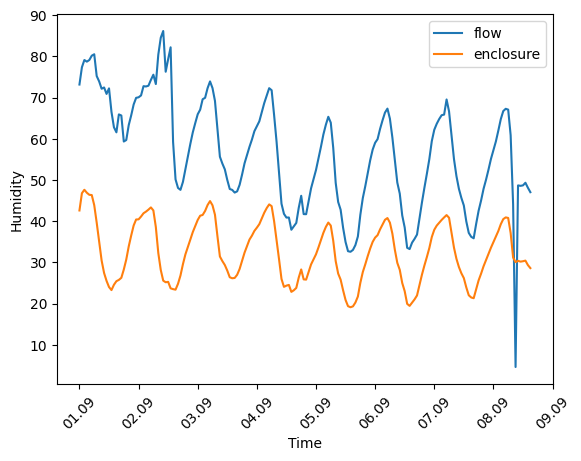

In [7]:
sns.lineplot(data=df_a.collect(), x="creation_timestamp", y="sht45_humidity", label = f"flow")
sns.lineplot(data=df_a.collect(), x="creation_timestamp", y="enclosure_bme280_humidity", label = f"enclosure")

# set axes labels
plt.xlabel("Time")
plt.ylabel('Humidity')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d.%m"))

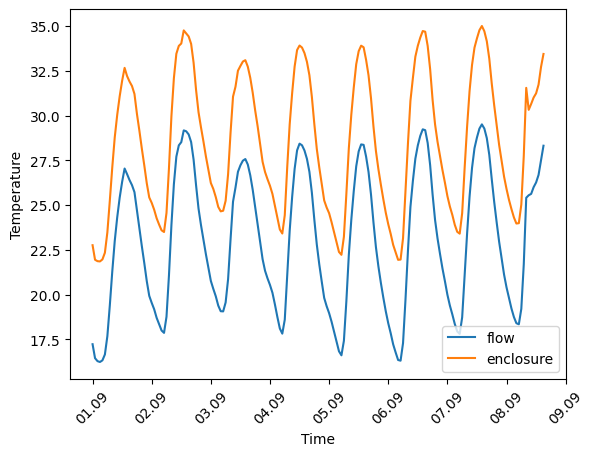

In [8]:
sns.lineplot(data=df_a.collect(), x="creation_timestamp", y="sht45_temperature", label = f"flow")
sns.lineplot(data=df_a.collect(), x="creation_timestamp", y="enclosure_bme280_temperature", label = f"enclosure")

# set axes labels
plt.xlabel("Time")
plt.ylabel('Temperature')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d.%m"))

In [9]:
df = df_a.join(df_p, left_on= "creation_timestamp", right_on= "creation_timestamp")
df.tail(3).collect()

creation_timestamp,system_name,variant,gmp343_raw,gmp343_compensated,gmp343_filtered,sht45_humidity,bme280_humidity,bme280_pressure,sht45_temperature,bme280_temperature,gmp343_temperature,cal_bottle_id,wxt532_speed_avg,wxt532_speed_max,wxt532_speed_min,wxt532_direction_avg,wxt532_direction_max,wxt532_direction_min,wxt532_last_update_time,raspi_cpu_usage,raspi_disk_usage,raspi_cpu_temperature,enclosure_bme280_humidity,enclosure_bme280_pressure,enclosure_bme280_temperature,cal_gmp343_raw,cal_gmp343_compensated,cal_gmp343_filtered,gmp343_compensated_corr,DATE,TIME,FRAC_DAYS_SINCE_JAN1,FRAC_HRS_SINCE_JAN1,JULIAN_DAYS,EPOCH_TIME,ALARM_STATUS,INST_STATUS,CavityPressure,CavityTemp,DasTemp,EtalonTemp,species,OutletValve,CH4,CH4_dry,CO2,CO2_dry,h2o_reported,ch4_base,ch4_pzt_std,co2_base,co2_pzt_std,wlm1_offset,wlm2_offset,datetime,__index_level_0__,CO2_corr
"datetime[μs, UTC]",str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,datetime[ns],f64,f64
2023-09-08 13:00:00 UTC,null,null,377.408333,413.636944,413.636944,49.319361,45.531,950.574222,26.684889,26.511722,28.9475,null,null,null,null,null,null,null,null,0.033286,0.382,54.196429,30.421429,960.410357,31.726429,null,null,null,433.707515,null,null,250.562335,6013.49603,251.562335,1.6942e9,0.0,963.0,139.999972,45.000724,44.471336,45.155048,2.046775,22661.889279,2.080997,2.129765,415.150155,427.04873,2.212455,1181.653118,80.29658,1084.854933,60.203819,-0.074561,-0.044626,null,3.967653e6,429.824957
2023-09-08 14:00:00 UTC,null,null,374.950418,412.389136,412.389136,48.114039,44.183315,950.307019,27.517131,27.352591,29.818106,null,null,null,null,null,null,null,null,0.033786,0.382,54.960714,29.343214,960.027143,32.708929,null,null,null,432.364367,null,null,250.604216,6014.50118,251.604216,1.6942e9,0.0,963.0,139.999921,45.000284,45.010594,45.153781,2.012164,22705.941429,2.081813,2.13006,413.257093,424.969423,2.189852,1181.623715,78.664242,1084.845815,60.14256,-0.074579,-0.044608,null,3.969655e6,427.732844
2023-09-08 15:00:00 UTC,null,null,373.95098,412.704412,412.704412,47.033186,42.983382,949.809265,28.315833,28.152402,30.742647,null,null,null,null,null,null,null,null,0.0338,0.382,55.42,28.606,959.966667,33.437333,null,null,null,432.703732,null,null,250.645943,6015.502635,251.645943,1.6942e9,0.0,963.0,140.000488,45.000331,45.353939,45.153769,2.013713,22730.283179,2.101069,2.151701,419.129657,431.487064,2.271273,1181.679637,78.425699,1084.873082,60.2267,-0.07452,-0.044555,null,3.971626e6,434.290627


<Axes: xlabel='gmp343_compensated_corr', ylabel='CO2_corr'>

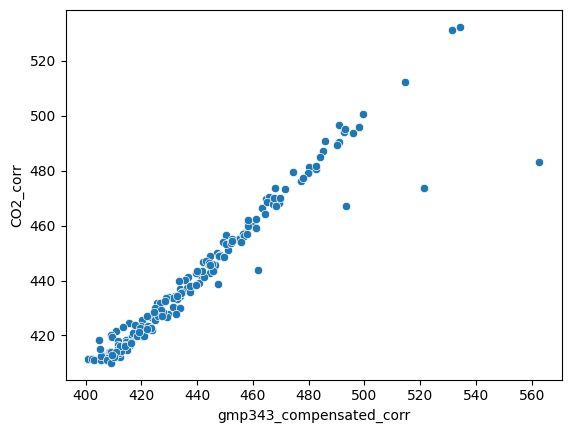

In [10]:
sns.scatterplot(data = df.collect(), x= "gmp343_compensated_corr", y = "CO2_corr" )